# Sentiment Analysis based on Amazon Product Reviews

The purpose of this analysis is to predict the sentiment, whether positive or negative, of just any given reviews. This is a binary classification analysis, so I will focus on the positive or negative sentiment of any product review. 

This analysis is based on Amazon Fine Food Reviews that span a period of more than 10 years, including all about 500,000 reviews up to October 2012.

To pre process natural language data, I will import the entire dataset, split train and test data, carry out major data cleaning process including word tokenizing, stopwords and punctuation removal, stemming, vetorizing, etc,.

With all data pro-processed and ready, I then load it into predictive algorithms, and check the ROC/AUC graph to see how robust is the model.

From then on, I'll see if this sentiment analysis is applicable on whether to improve the video comments.

At the end, I put everything down to one single function that takes any given string and return sentiment prediction. Welcome to try it out!

## 1. Prepare the Data

### a) Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import data
df=pd.read_csv('Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
# check data dimension
df.shape

(568454, 10)

In [4]:
# check input data completeness
df[df['Summary']==np.nan]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


In [5]:
# check output data completeness
df[df['Score']==np.nan]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


Seems all data are complete with zero null spaces :)

(array([ 52268.,  29769.,  42640.,  80655., 363122.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <BarContainer object of 5 artists>)

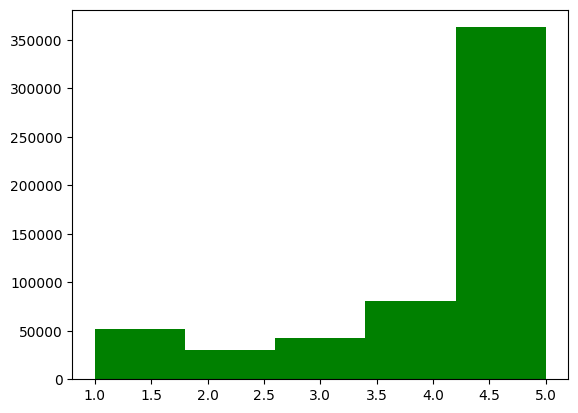

In [6]:
# check score histogram
plt.hist(df['Score'],bins=5,color='green')

Here I will convert each score into sentiment.

A review is regarded positive if the score is greater than 3 and negative otherwise. 

In [7]:
# convert score to sentiment
sentiment=df['Score'].apply(lambda score: 1 if score>3 else 0) # 1 is positive and 0 negative
df['Sentiment']=sentiment
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1


Now I'm ready to split train and test data.

### b) Split train data and test data

In [8]:
# split training data and testing data
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(df['Summary'],df['Sentiment'],train_size=0.8)

In order to let the machine know these reviews, I will have to convert each review from string to vectors.

The following steps will do exactly that.

## 2. Data Pre-processing

In [9]:
# data pre-processing
import nltk
import re

### a) Word tokenizing
This will convert strings into separate tokens, so that it's easier to work on each word in any string, including punctuation and stopwords removal, stemming and vectorizing.

In [10]:
# word tokenizing
def tokenize(arr):
    for i in arr.keys():
        arr[i]=re.sub(r'[0-9]+', '', str(arr[i])) # remove numbers
        arr[i]=nltk.word_tokenize(arr[i])
    return arr
tokens = tokenize(X_train)
tokens

139630                     [Too, pricey, for, cat, food]
173525                                [TERRIBLE, COFFEE]
100627                        [So, good, !, Love, it, .]
193535                              [Sweet, and, Golden]
151987                                   [very, good, !]
                               ...                      
436375          [Filling, but, absolutely, tasteless, .]
561142     [Longest, lasting, dog, treat, I, 've, found]
495613                                              [PB]
326592    [Good, Tasting, Decaf, Coffee, -, Recommended]
92475                                   [not, the, same]
Name: Summary, Length: 454763, dtype: object

### b) Punctuation and stopwords removal
Stopwords are words that do not necessarily carry sentiments. They should be removed before data training since they might affect the model precision.

In [11]:
# punctuationand stopwords removal
def remove_num_pun_stops(arr):
    import string
    punctuation=string.punctuation
    stopwords=nltk.corpus.stopwords.words('english')
    for i in arr.keys():
        if not isinstance(arr[i],float):
            arr[i]=[w.lower() for w in arr[i] if w.lower() not in punctuation and w.lower() not in stopwords]
    return arr

tokens_wo_num_pun_stops=remove_num_pun_stops(tokens)
tokens_wo_num_pun_stops

139630                            [pricey, cat, food]
173525                             [terrible, coffee]
100627                                   [good, love]
193535                                [sweet, golden]
151987                                         [good]
                             ...                     
436375               [filling, absolutely, tasteless]
561142     [longest, lasting, dog, treat, 've, found]
495613                                           [pb]
326592    [good, tasting, decaf, coffee, recommended]
92475                                              []
Name: Summary, Length: 454763, dtype: object

### c) Stemming
Here I will convert each of the tokens into stems. Stemming is a process that converts each word into its stem. This will significantly decrease the number of features in the model and thus drops the training time without sacrificing the precision of the model.

In [12]:
# stemming and converting arrays into strings
ps=nltk.stem.PorterStemmer()
def stem(arr):
    for i in arr.keys():
        if not isinstance(arr[i],float):
            arr[i]=' '.join([ps.stem(w) for w in arr[i]]) # convert lists back to strings
    return arr
stems = stem(tokens_wo_num_pun_stops)
stems

139630                     pricey cat food
173525                       terribl coffe
100627                           good love
193535                        sweet golden
151987                                good
                        ...               
436375              fill absolut tasteless
561142    longest last dog treat 've found
495613                                  pb
326592     good tast decaf coffe recommend
92475                                     
Name: Summary, Length: 454763, dtype: object

### d) Word vectorizing
Now I will convert all the stems in each string into a vector. This is also called one-hot encoding.

This process takes a string of words and returns a vector. Each of these vectors will be in shape (1,N) where N is the number of features, usually determined by the number of stems in the entire training data. However I limit N to be 1000 just because my laptop can't train a model on that many features.

I also set my ngram_range to be (1,2), which means this is a unigram and bigram model, just in case I overlooked some word combinations that play significant role in the output.

In [13]:
# word vectorizing
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer(
    lowercase=True,
    ngram_range=(1,2),
    stop_words='english',
    max_features=1000, # limit number of features to be 200
    token_pattern=r'(?u)\b[A-Za-z]+\b' # Requested the token pattern to be number-free
)
V=vectorizer.fit(stems) # vectorizing

# This is the vectorizer we will be using later on
V

TfidfVectorizer(max_features=1000, ngram_range=(1, 2), stop_words='english',
                token_pattern='(?u)\\b[A-Za-z]+\\b')

In [14]:
# one-hot encoding 
one_hot_encoded_matrix=V.transform(stems).toarray()

# This is the matrix generated with one-hot encoding
one_hot_encoded_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

BAM!

Later I will use this vector space as the train input data in logistic regression model and random forest model.

In [15]:
# check features
features=V.get_feature_names_out()
features

array(['absolut', 'absolut best', 'absolut delici', 'acid', 'actual',
       'ad', 'add', 'addict', 'addit', 'adult', 'advertis', 'afford',
       'aftertast', 'agre', 'allergi', 'almond', 'altern', 'alway',
       'amaz', 'amazon', 'anoth', 'anyon', 'anyth', 'appl', 'approv',
       'aroma', 'arriv', 'artifici', 'assort', 'authent', 'avail',
       'averag', 'aw', 'away', 'awesom', 'awesom product', 'b', 'babi',
       'babi food', 'babi love', 'bacon', 'bad', 'bad tast', 'bag',
       'bake', 'balanc', 'ball', 'banana', 'bar', 'bargain', 'base',
       'basic', 'batch', 'bbq', 'bean', 'bear', 'beat', 'beauti', 'beef',
       'beef jerki', 'beer', 'believ', 'belli', 'benefit', 'berri',
       'best', 'best chip', 'best chocol', 'best coffe', 'best cooki',
       'best dog', 'best flavor', 'best gf', 'best gluten', 'best hot',
       'best instant', 'best k', 'best popcorn', 'best price',
       'best snack', 'best tast', 'best tea', 'best ve', 'better',
       'better expect', 'bevera

Since this is a binary classification problem Here I'll use logictic regression and random forest model to try to fit these data.

## 4. Logistic regression

### a) model fitting

In [16]:
# logistic regression fitting
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(max_iter=len(X_train)) # I have to set the max_iter here because otherwise it will stop by itself
model.fit(one_hot_encoded_matrix,Y_train)

LogisticRegression(max_iter=454763)

### b) Visualize feature importance
Here I am only going to visualize some of the most important features since I have 1000 features in my model.

<Axes: ylabel='Feature'>

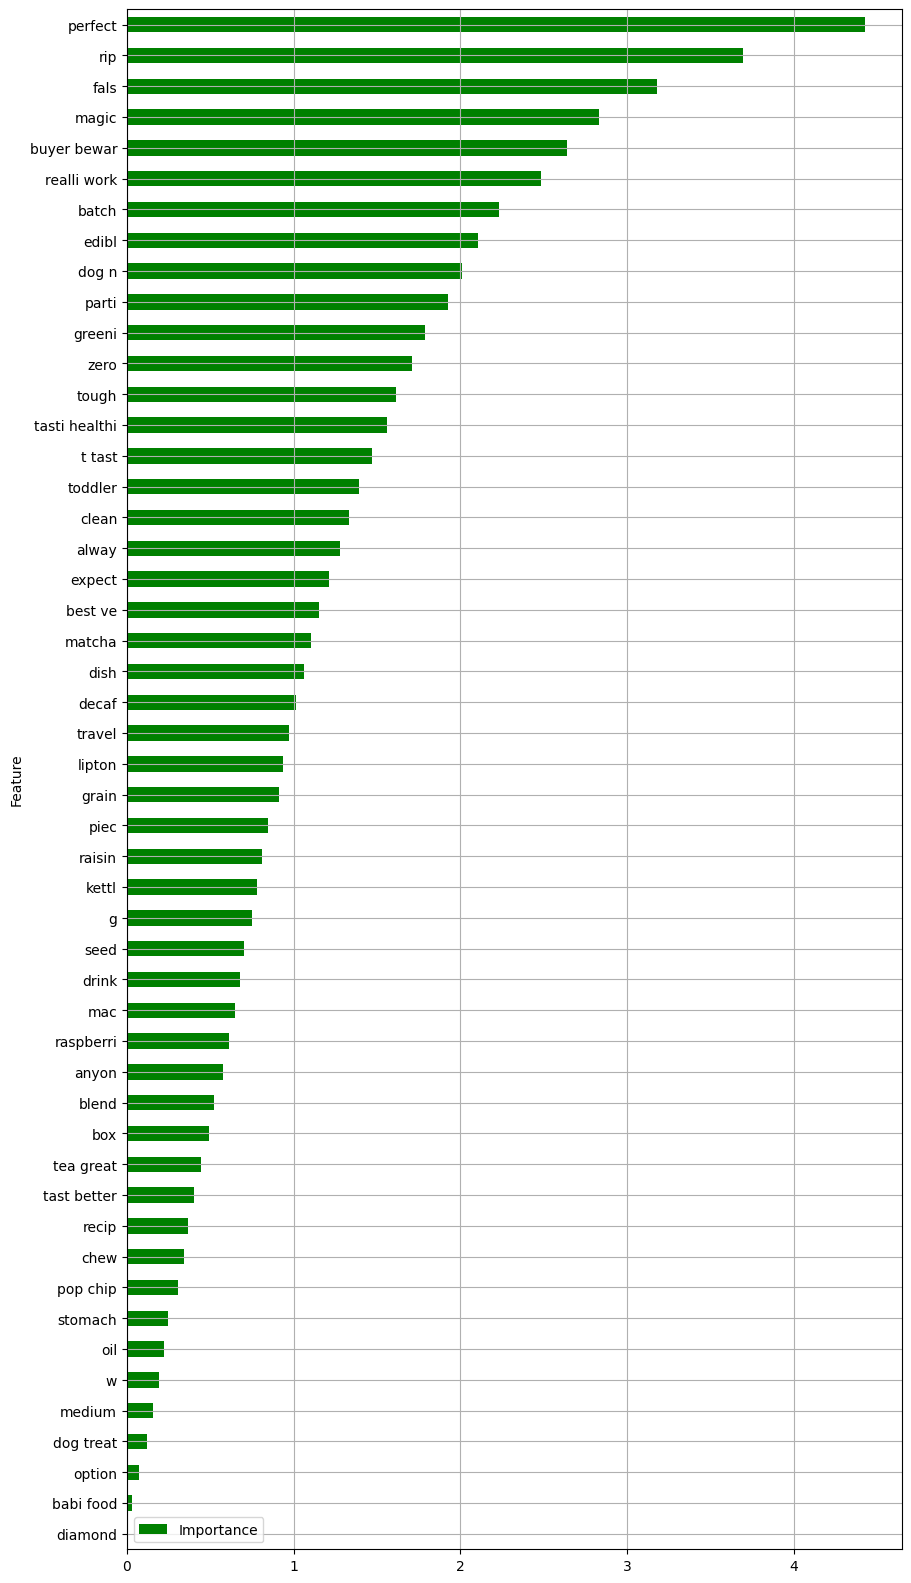

In [17]:
# visualize select feature importance
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature':features,'Importance':np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance',ascending=True)[::20]
feature_importance.plot(x='Feature',y='Importance',kind='barh',figsize=(10,20),color='green',grid=True)

### c) Testing
In order to test the model, I will have to first convert all test data into vectors and then plug them into the model. 

In [18]:
# define a function that converts strings to vector inputs
def Str2Vec(data):
    tokens=tokenize(data) # tokenizing
    tokens_wo_num_pun_stops=remove_num_pun_stops(tokens) # stopwords, punctuation and number removal
    stems = stem(tokens_wo_num_pun_stops) # stemming
    return V.transform(stems).toarray() # vectorizing

test_input=Str2Vec(X_test) # this will transform test input into vectors
test_input

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### d) Evaluation
Here I'll use f1-score and accuracy score to evaluate this model.

In [19]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(Y_test, model.predict(test_input)))

              precision    recall  f1-score   support

           0       0.76      0.45      0.56     24857
           1       0.86      0.96      0.91     88834

    accuracy                           0.85    113691
   macro avg       0.81      0.70      0.74    113691
weighted avg       0.84      0.85      0.83    113691



With F1-score of 0.91 and accuracy score of 0.85, I think this logistic model is somewhat ok for analysis. But I would try random forest model as well just for comparison.

## 5. Random Forest
### a) model fitting

In [20]:
from sklearn.ensemble import RandomForestClassifier

In order to run Random Forest Fitment, I would scale down the sample size a little bit, otherwise it won't go through.

In [21]:
X_train2,X_test2,Y_train2,Y_test2=train_test_split(df['Summary'],df['Sentiment'],train_size=0.1)

In [22]:
train_vector=Str2Vec(X_train2)

In [23]:
model2=RandomForestClassifier()
model2.fit(train_vector,Y_train2)

RandomForestClassifier()

### b) evaluation
Same evaluation method is applied here.

In [25]:
# input vectorization
test_vector=Str2Vec(X_test2)

In [26]:
# classification report
print(classification_report(Y_test2,model2.predict(test_vector)))

              precision    recall  f1-score   support

           0       0.74      0.50      0.60    112179
           1       0.87      0.95      0.91    399430

    accuracy                           0.85    511609
   macro avg       0.81      0.73      0.75    511609
weighted avg       0.84      0.85      0.84    511609



With accuracy score of 0.85 and F1 score of 0.91, Random Forest model works just as accurate as linear regression model here.

## 6. Save Model and Restore
By saving model locally, I don't need to train my model everytime when I want to use it.

In [27]:
import joblib

In [28]:
joblib.dump(model,'LR_model') # This is to save the logistic regression model

['LR_model']

In [29]:
joblib.dump(model2,'RF_model') # This is to save the Random Forest model

['RF_model']

In [30]:
Logistic_Regression=joblib.load('LR_model') # This is to load the logistic regression model

In [31]:
Random_Forest=joblib.load('RF_model')# This is to load the random forest model

## 7. Sentiment Function
Based on all the analysis above, this function will take any string and return a sentiment prediction.

In [32]:
# Now let's try to implement all above into one single function with logistic regression
# This function will take any string and return a sentiment prediction

import string
punctuation=string.punctuation
stopwords=nltk.corpus.stopwords.words('english')

def Sentiment(str):
    str=re.sub(r'[0-9]+', '', str) # remove numbers
    str=nltk.word_tokenize(str) # tokenize string
    # punctuation, numbers and stopwords removal
    str=[w.lower() for w in str if w.lower() not in punctuation and w.lower() not in stopwords]
    # stemming
    stems=' '.join([ps.stem(w) for w in str])
    one_hot_codes=V.transform(np.array([stems])).toarray()
    sentiment=Random_Forest.predict(one_hot_codes) # Note that here I use random forest model to predict the sentiment result
    return 'positive' if sentiment==1 else 'negative'

In [33]:
#let's try the model
Sentiment('This is great!')

'positive'

BAM!

In [34]:
Sentiment('This is disgusting!')

'negative'

In [35]:
Sentiment('i am disappointed in myself')

'negative'

In [36]:
Sentiment('but i can do this')

'positive'

## 8. Final Thought
Despite the fact that my laptop cannot fit more models other than Random Forest and Logistic Regression, I think they both did a fairly ok job in terms of prediction.

In terms of model restoration, simply import joblib and dump the model in joblib file. That way when you use the model, you don't have to train it all over again.

I think the original dataset might be a little biased towards positive since this is a fine food dataset and people are generally more inclined to give high scores to justify their purchase. If the review dataset were from a more general category, the model should be more accurate.

In terms of whether to promote the video commenting to users, I think it's a clear yes. We can even dive deeper to integrate real-time audio-to-caption converter so that as user records the video, the sentiment prediction will automatically pop up. If wrong, we also allow users to change their review ratings manually.

By doing so, language sentiment model will be more and more sensitive and accurate, and maybe one day this could be integrated in AWS as a part of service too.